In [1]:
##Install Required Packages
pip install pandas numpy matplotlib arch openpyxl


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 981.3/981.3 kB 14.5 MB/s eta 0:00:00


In [2]:
##Data Cleaning

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from arch import arch_model

# Load data
df = pd.read_excel("/content/ISHITA_GARCH.xlsx")

# Keep only the useful columns
price_cols = ["NSEBANK Index", "NSEAUTO Index", "NSEFMCG Index", "NSEIT Index", "NIFTY Index"]
df = df[["DATE"] + price_cols].dropna()

# Set datetime index
df["DATE"] = pd.to_datetime(df["DATE"])
df = df.set_index("DATE").sort_index()

# Compute log returns (in % terms to be interpretable)
returns = np.log(df).diff()*100
returns = returns.dropna()

returns.head()


,NSEBANK Index,NSEAUTO Index,NSEFMCG Index,NSEIT Index,NIFTY Index
DATE,,,,,
2015-01-02,1.625871,0.558614,0.423132,1.384840,1.336395
2015-01-05,-0.212212,1.218430,0.209287,-1.092376,-0.203293
2015-01-06,-3.133388,-2.629345,-1.605600,-2.599607,-3.042205
2015-01-07,-0.688719,0.078774,-0.112078,-0.401355,-0.311163
2015-01-08,2.146511,1.712749,2.011032,0.931431,1.622150


In [3]:
##Fit EGARCH Model

def fit_egarch(series):
    """
    series: pandas Series of returns
    returns: fitted model result object
    """
    model = arch_model(
        series,
        vol="EGARCH",  # Exponential GARCH
        p=1, q=1,      # EGARCH(1,1)
        dist="t"       # Student-t innovations
    )
    res = model.fit(disp="off")
    return res


In [4]:
## Fit TGARCH Model

def fit_tgarch(series):
    """
    TGARCH / GJR-GARCH(1,1) with one asymmetric term.
    """
    model = arch_model(
        series,
        vol="GARCH",   # base
        p=1, o=1, q=1, # p=ARCH lag, o=asymmetry term, q=GARCH lag
        dist="t"
    )
    res = model.fit(disp="off")
    return res


In [5]:
sectors = {
    "Banks": "NSEBANK Index",
    "Auto": "NSEAUTO Index",
    "FMCG": "NSEFMCG Index",
    "IT": "NSEIT Index",
    "Nifty (Benchmark)": "NIFTY Index"
}

results_summary = []
vol_series = {}  # to store conditional volatility paths for plotting later

for sector_name, col in sectors.items():
    y = returns[col].dropna()

    # EGARCH fit
    egarch_res = fit_egarch(y)
    egarch_params = egarch_res.params  # omega, alpha[1], gamma[1], beta[1], etc.

    # EGARCH persistence ~ beta[1]
    egarch_beta = egarch_params.get("beta[1]", np.nan)
    egarch_gamma = egarch_params.get("gamma[1]", np.nan)
    egarch_alpha = egarch_params.get("alpha[1]", np.nan)

    # Store conditional volatility (annualize optional, but we'll keep daily % stdev interpretation)
    vol_series[(sector_name, "EGARCH")] = egarch_res.conditional_volatility

    # --- TGARCH fit ---
    tgarch_res = fit_tgarch(y)
    tgarch_params = tgarch_res.params
    # In a TGARCH(1,1):
    # variance_t = omega + alpha * eps_{t-1}^2 + gamma * I(eps_{t-1}<0)*eps_{t-1}^2 + beta * var_{t-1}
    tgarch_alpha = tgarch_params.get("alpha[1]", np.nan)
    tgarch_gamma = tgarch_params.get("gamma[1]", np.nan)
    tgarch_beta  = tgarch_params.get("beta[1]", np.nan)

    # Short-run shock impact if shock is negative:
    #   alpha + gamma
    short_run_impact_bad = tgarch_alpha + tgarch_gamma
    # Long-run persistence approximation often discussed in GJR-GARCH:
    #   alpha + beta + gamma/2
    long_run_persist = tgarch_alpha + tgarch_beta + (tgarch_gamma / 2)

    vol_series[(sector_name, "TGARCH")] = tgarch_res.conditional_volatility

    # collect summary row for this sector
    results_summary.append({
        "Sector": sector_name,
        "EGARCH_alpha(1)": egarch_alpha,
        "EGARCH_gamma(1)": egarch_gamma,
        "EGARCH_beta(1)_persistence": egarch_beta,
        "TGARCH_alpha(1)": tgarch_alpha,
        "TGARCH_gamma(1)": tgarch_gamma,
        "TGARCH_beta(1)": tgarch_beta,
        "TGARCH_short_run_impact_bad(alpha+gamma)": short_run_impact_bad,
        "TGARCH_long_run_persistence(alpha+beta+gamma/2)": long_run_persist
    })

summary_df = pd.DataFrame(results_summary)
print(summary_df)


              Sector  EGARCH_alpha(1)  EGARCH_gamma(1)  \
0              Banks         0.173207              NaN   
1               Auto         0.173546              NaN   
2               FMCG         0.125855              NaN   
3                 IT         0.124861              NaN   
4  Nifty (Benchmark)         0.174216              NaN   

   EGARCH_beta(1)_persistence  TGARCH_alpha(1)  TGARCH_gamma(1)  \
0                    0.982705     2.785725e-02         0.094064   
1                    0.971810     1.982899e-02         0.103902   
2                    0.970296     2.752542e-02         0.043813   
3                    0.975154     2.731256e-02         0.045261   
4                    0.974593     2.150729e-16         0.138059   

   TGARCH_beta(1)  TGARCH_short_run_impact_bad(alpha+gamma)  \
0        0.903530                                  0.121922   
1        0.890404                                  0.123731   
2        0.905965                                  0.071339

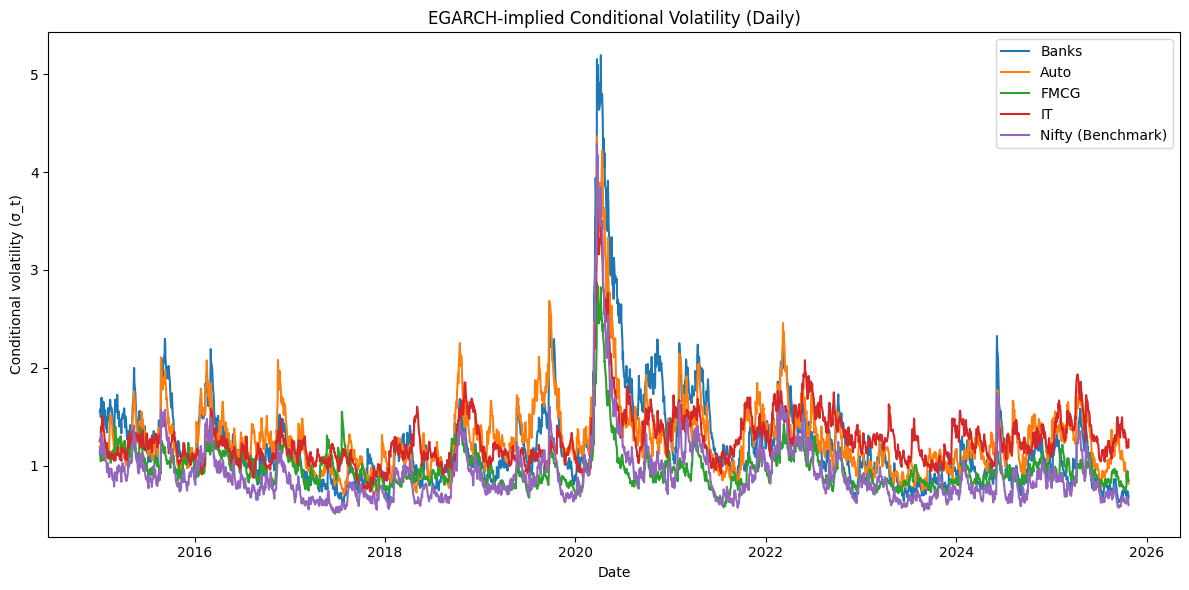

In [6]:
##plot conditional volitality to analyse "when did the each sector panic?"

plt.figure(figsize=(12,6))

for sector_name, col in sectors.items():
    vol_path = vol_series[(sector_name, "EGARCH")]
    plt.plot(vol_path.index, vol_path, label=sector_name)

plt.title("EGARCH-implied Conditional Volatility (Daily)")
plt.ylabel("Conditional volatility (σ_t)")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


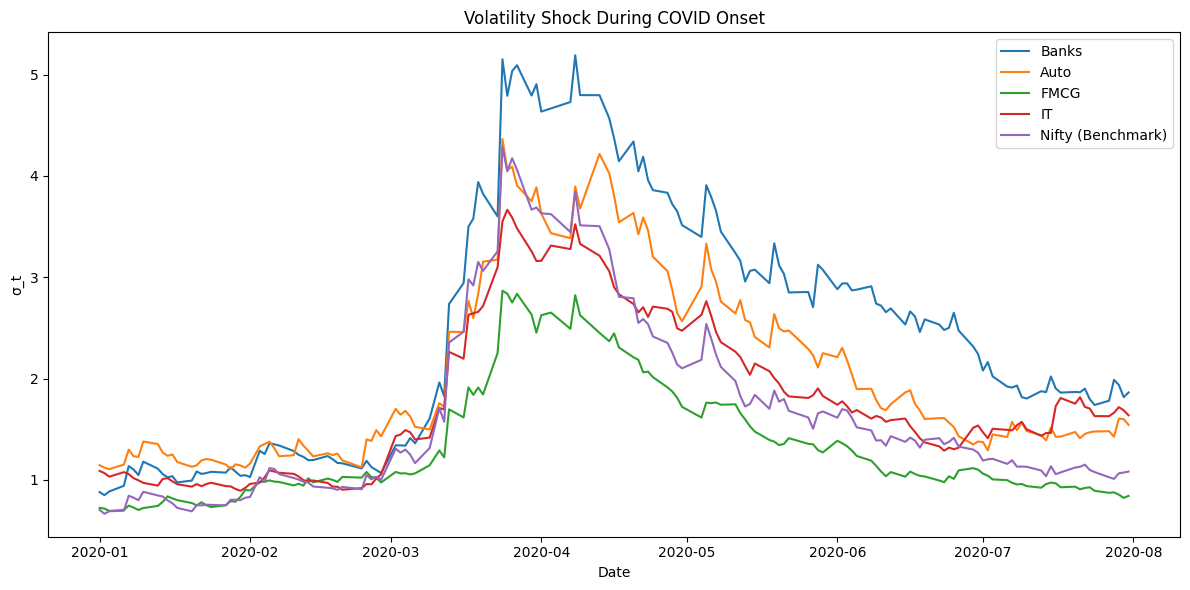

In [7]:
covid_slice = slice("2020-01-01", "2020-07-31")
plt.figure(figsize=(12,6))
for sector_name, col in sectors.items():
    vol_path = vol_series[(sector_name, "EGARCH")].loc[covid_slice]
    plt.plot(vol_path.index, vol_path, label=sector_name)

plt.title("Volatility Shock During COVID Onset")
plt.ylabel("σ_t")
plt.xlabel("Date")
plt.legend()
plt.tight_layout()
plt.show()


In [8]:
##Significance Check

for sector_name, col in sectors.items():
    y = returns[col].dropna()
    egarch_res = fit_egarch(y)
    print("\n=== ", sector_name, " EGARCH(1,1) ===")
    print(egarch_res.summary())  # includes t-stats and p-values

    tgarch_res = fit_tgarch(y)
    print("\n=== ", sector_name, " TGARCH(1,1) ===")
    print(tgarch_res.summary())



===  Banks  EGARCH(1,1) ===
                        Constant Mean - EGARCH Model Results                        
Dep. Variable:                NSEBANK Index   R-squared:                       0.000
Mean Model:                   Constant Mean   Adj. R-squared:                  0.000
Vol Model:                           EGARCH   Log-Likelihood:               -4085.79
Distribution:      Standardized Student's t   AIC:                           8181.59
Method:                  Maximum Likelihood   BIC:                           8211.05
                                              No. Observations:                 2679
Date:                      Mon, Oct 27 2025   Df Residuals:                     2678
Time:                              06:49:25   Df Model:                            1
                                Mean Model                                
                 coef    std err          t      P>|t|    95.0% Conf. Int.
--------------------------------------------------------